In [2]:
import torch
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

from args import Args

from models import build_model

from util.dataset import get_datasets, get_sample_from_dataloader
import util.misc as utils
from util.mask_utils import mask_known_regions

from util.visualization import draw_boxes, tensor_to_img

from datasets.coco import make_coco_transforms
from torch.utils.data import DataLoader

/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'OWDETR': ('aeroplane', 'bicycle', 'bird', 'boat', 'bus', 'car', 'cat', 'cow', 'dog', 'horse', 'motorbike', 'sheep', 'train', 'elephant', 'bear', 'zebra', 'giraffe', 'truck', 'person', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'chair', 'diningtable', 'pottedplant', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'bed', 'toilet', 'sofa', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'tvmonitor', 'bottle', 'unknown'), 'TOWOD': ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',

In [3]:
# ---- Load Model ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args()

# 모델과 postprocessor 준비
model, _, postprocessors, exemplar_selection, contextual_labeling = build_model(args, mode=args.model_type)
model.to(device)

# 체크포인트 로드 (옵션) / Load checkpoint (optional)
checkpoint = torch.load("./test_model/MOWODB/t1.pth", map_location=device)
model.load_state_dict(checkpoint['model'], strict=False)
model.eval()

Invalid class range: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
DINO resnet50


/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/dan/anaconda3/envs/torch-cuda11/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


running with exemplar_replay_selection
Initialized Contextual Labeling Module


DeformableDETR(
  (transformer): DeformableTransformer(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affin

In [4]:
class_names = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'truck', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'bed', 'toilet', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'unknown']

dataset_train, dataset_val = get_datasets(args)

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, args.batch_size, drop_last=True)
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)

TOWOD


In [80]:
# ---- Load Image ----
image, target = get_sample_from_dataloader(data_loader_val, 1246)

# ---- Step 1: Inference for Known ----
with torch.no_grad():
    outputs = model(image.to(device))
    outputs = postprocessors['bbox'](outputs, target['size'].unsqueeze(0).to(device))[0]


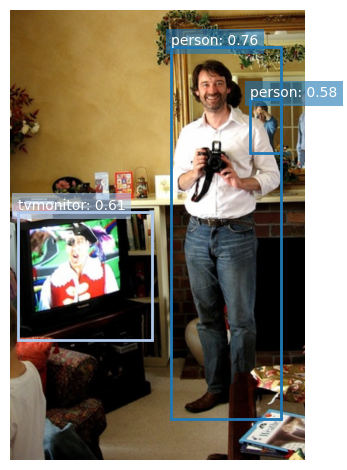

In [81]:
orig_image = tensor_to_img(image)

# ---- Step 1: Filter Known Boxes ----
known_score_threshold = 0.5
unknown_score_threshold = 0.7

scores = outputs['scores'].cpu()
labels = outputs['labels'].cpu()
boxes = outputs['boxes'].cpu()

# score threshold 적용
known_keep = (labels < 80) & (scores > known_score_threshold)
unknown_keep = (labels == 80) & (scores > unknown_score_threshold)
keep = known_keep #| unknown_keep
scores = scores[keep]
labels = labels[keep]
boxes = boxes[keep]

result_image = draw_boxes(orig_image, scores, labels, boxes, class_names=class_names, font_scale=1.5)  # 시각화 (선택)

In [82]:
# ---- Step 2: Mask Image and Re-run ----
# Define the transform pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

masked_image = mask_known_regions(orig_image, boxes, mask_type='black')
masked_tensor = transform(masked_image).unsqueeze(0).to(device)

with torch.no_grad():
    masked_outputs = model(masked_tensor)
    masked_outputs = postprocessors['bbox'](masked_outputs, target['size'].unsqueeze(0).to(device))[0]

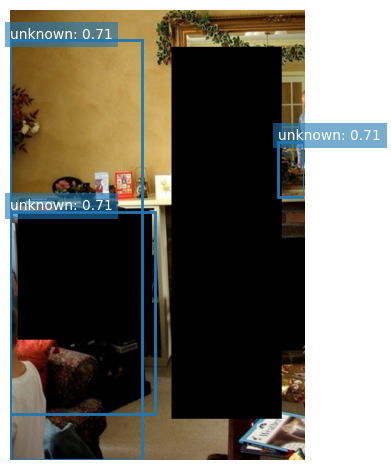

In [83]:
# ---- Step 2: Filter Unknown Boxes ----
known_score_threshold = 0.5
unknown_score_threshold = 0.7

masked_scores = masked_outputs['scores'].cpu()
masked_labels = masked_outputs['labels'].cpu()
masked_boxes = masked_outputs['boxes'].cpu()

# score threshold 적용
masked_known_keep = (masked_labels < 80) & (masked_scores > known_score_threshold)
masked_unknown_keep = (masked_labels == 80) & (masked_scores > unknown_score_threshold)
masked_keep = masked_known_keep | masked_unknown_keep
masked_scores = masked_scores[masked_keep]
masked_labels = masked_labels[masked_keep]
masked_boxes = masked_boxes[masked_keep]

masked_result_image = draw_boxes(masked_image, masked_scores, masked_labels, masked_boxes, class_names=class_names, font_scale=1.5)  # 시각화 (선택)